# Tire Degradation Prediction Model - Week 5

## Overview
This notebook implements advanced models to predict tire degradation in Formula 1 races. Since tire degradation is not strictly linear and depends on multiple factors (compound type, track temperature, driving style, etc.), we'll use sequence models like LSTM to capture these complex patterns.

## Approach
1. **Data Exploration**
   - Analyze the relationship between lap times and tire age
   - Visualize performance degradation patterns by compound
   - Determine how to quantify "degradation" (lap time delta or derived metric)

2. **Feature Engineering**
   - Create a derived tire degradation metric
   - Organize data into sequential format for LSTM
   - Normalize features appropriately
   - Create sliding windows of previous laps to predict future performance

3. **Model Development**
   - **Primary Model**: LSTM network to predict degradation trajectory
   - **Alternative Model**: XGBoost with quantile regression for uncertainty estimation

4. **Evaluation & Visualization**
   - Compare predicted vs. actual degradation curves
   - Analyze performance across different compounds and race conditions
   - Create interactive Plotly visualizations of degradation patterns

5. **Implementation Details**
   - Sequence length: 5 laps (input) → predict next 3-5 laps
   - Features: Tire age, compound, lap time trends, fuel load
   - Target: Derived degradation metric or direct lap time prediction

## Expected Outcomes
- Trained model to predict tire performance over extended stints
- Uncertainty bounds for degradation predictions (10th, 50th, 90th percentiles)
- Interactive visualization of degradation curves by compound

---

## 1. Importing Necessary Libraries and Creatind New Directories

In [17]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import os



In [18]:
# Set plot style
plt.style.use('ggplot')
sns.set(style="whitegrid")

# Create output directories if they don't exist
os.makedirs('../../outputs/week5', exist_ok=True)
os.makedirs('../../models/week5', exist_ok=True)

---

## 2. Loading Dataframes

In [19]:
data = pd.read_csv("../../outputs/week3/lap_prediction_data.csv")
print("\nRegular data sample:")
display(data.head())


Regular data sample:


,Unnamed: 0,LapTime,Stint,SpeedI1,SpeedI2,SpeedFL,SpeedST,Position,LapsSincePitStop,DRSUsed,TeamID,CompoundID,TyreAge,FuelLoad,DriverNumber
0,0,83.935,1.0,256.0,261.0,276.0,275.0,1.0,1.0,0,9,2,1.0,0.9848,1
1,1,80.402,1.0,252.0,257.0,276.0,295.0,1.0,2.0,0,9,2,2.0,0.9697,1
2,2,80.499,1.0,249.0,256.0,276.0,297.0,1.0,3.0,0,9,2,3.0,0.9545,1
3,3,80.346,1.0,255.0,256.0,276.0,300.0,1.0,4.0,0,9,2,4.0,0.9394,1
4,4,80.283,1.0,254.0,256.0,277.0,301.0,1.0,5.0,0,9,2,5.0,0.9242,1


In [20]:
seq_data = pd.read_csv("../../outputs/week3/sequential_lap_prediction_data.csv")
print("\nSequential data sample:")
display(seq_data.head())


Sequential data sample:


,Unnamed: 0.1,Unnamed: 0,LapTime,Stint,SpeedI1,SpeedI2,SpeedFL,SpeedST,Position,LapsSincePitStop,...,Prev_SpeedI2,Prev_SpeedFL,Prev_SpeedST,Prev_TyreAge,LapTime_Delta,SpeedI1_Delta,SpeedI2_Delta,SpeedFL_Delta,SpeedST_Delta,LapTime_Trend
0,1,1.0,80.402,1.0,252.0,257.0,276.0,295.00,1.0,2.0,...,261.0,276.0,275.0,1.0,-3.533,-4.0,-4.0,0.0,20.00,0.000
1,2,2.0,80.499,1.0,249.0,256.0,276.0,297.00,1.0,3.0,...,257.0,276.0,295.0,2.0,0.097,-3.0,-1.0,0.0,2.00,3.630
2,3,3.0,80.346,1.0,255.0,256.0,276.0,300.00,1.0,4.0,...,256.0,276.0,297.0,3.0,-0.153,6.0,0.0,0.0,3.00,-0.250
3,4,4.0,80.283,1.0,254.0,256.0,277.0,301.00,1.0,5.0,...,256.0,276.0,300.0,4.0,-0.063,-1.0,0.0,1.0,1.00,0.090
4,5,5.0,80.402,1.0,255.0,253.0,276.0,309.85,1.0,6.0,...,256.0,277.0,301.0,5.0,0.119,1.0,-3.0,-1.0,8.85,0.182


In [21]:
# Display basic information
print("Basic dataset information:")
print(f"Regular data shape: {data.shape}")
print(f"Sequential data shape: {seq_data.shape}")

Basic dataset information:
Regular data shape: (1180, 15)
Sequential data shape: (1118, 28)


In [22]:
# Check for available tire-related columns
tire_columns = [col for col in data.columns if 'tyre' in col.lower() or 'tire' in col.lower() or 'compound' in col.lower()]
print(f"\nTire-related columns: {tire_columns}")


Tire-related columns: ['CompoundID', 'TyreAge']


In [23]:
# Summary statistics for tire-related columns
print("\nTire-related statistics:")
display(data[tire_columns].describe())


Tire-related statistics:


,CompoundID,TyreAge
count,1180.000000,1180.000000
mean,2.188136,13.760169
std,0.800887,8.002074
min,1.000000,1.000000
25%,2.000000,7.000000
50%,2.000000,13.000000
75%,3.000000,19.000000
max,3.000000,50.000000


In [24]:
from ML_utils.lap_prediction import compound_colors, compound_names

print(compound_names)
print(compound_colors)

{1: 'SOFT', 2: 'MEDIUM', 3: 'HARD', 4: 'INTERMEDIATE', 5: 'WET'}
{1: 'red', 2: 'yellow', 3: 'gray', 4: 'green', 5: 'blue'}


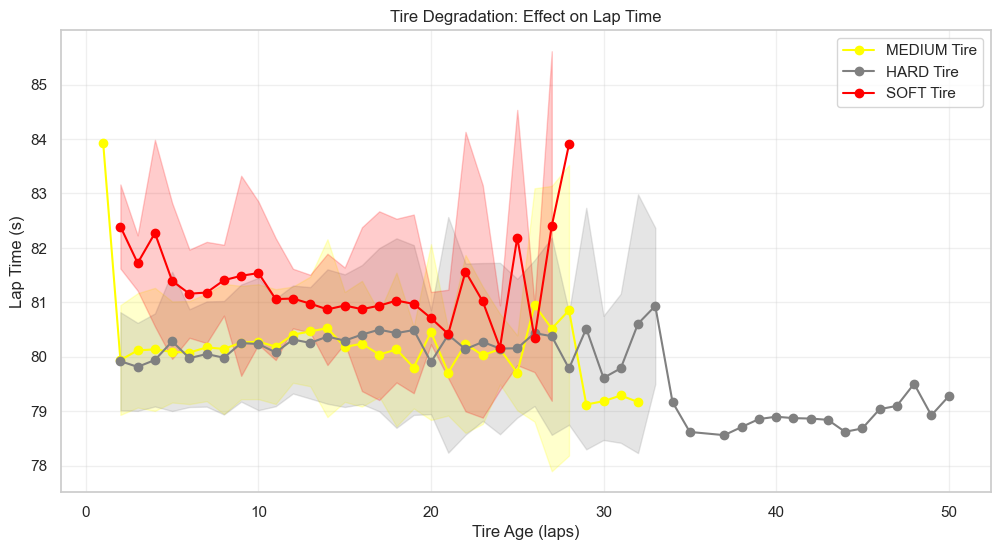

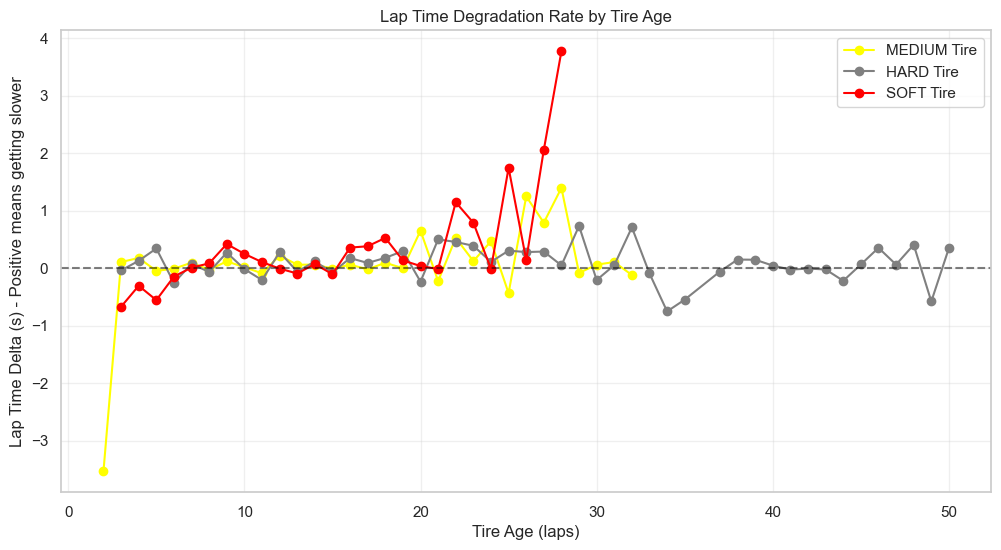

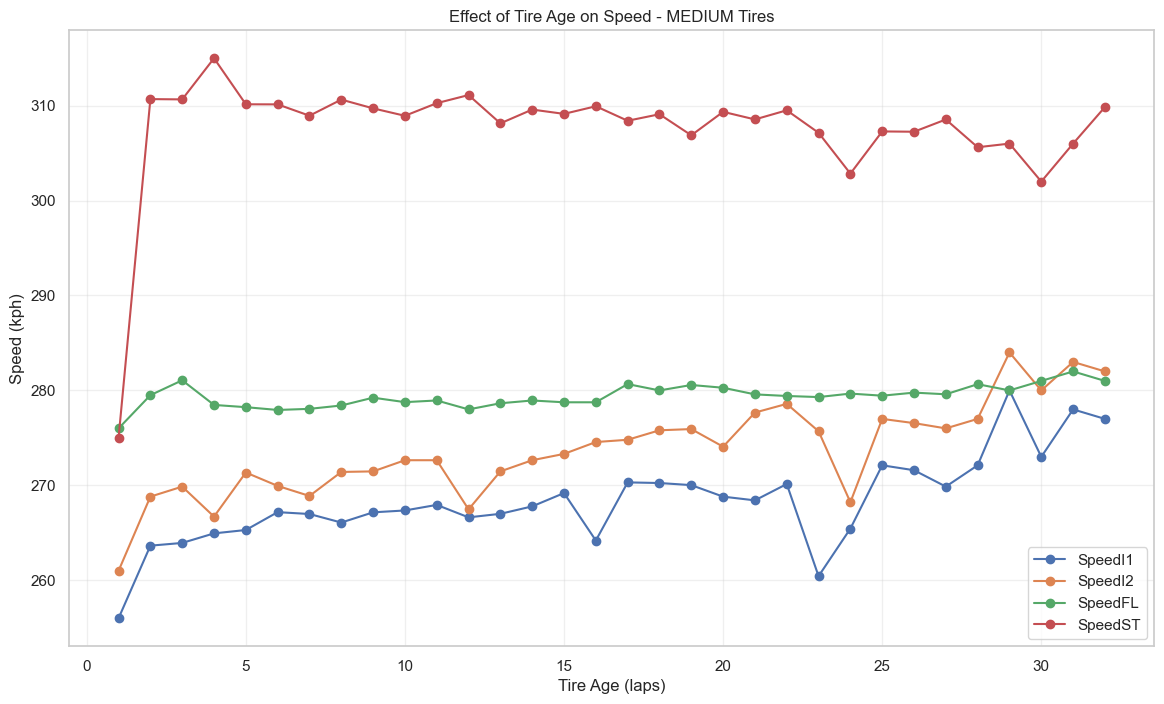

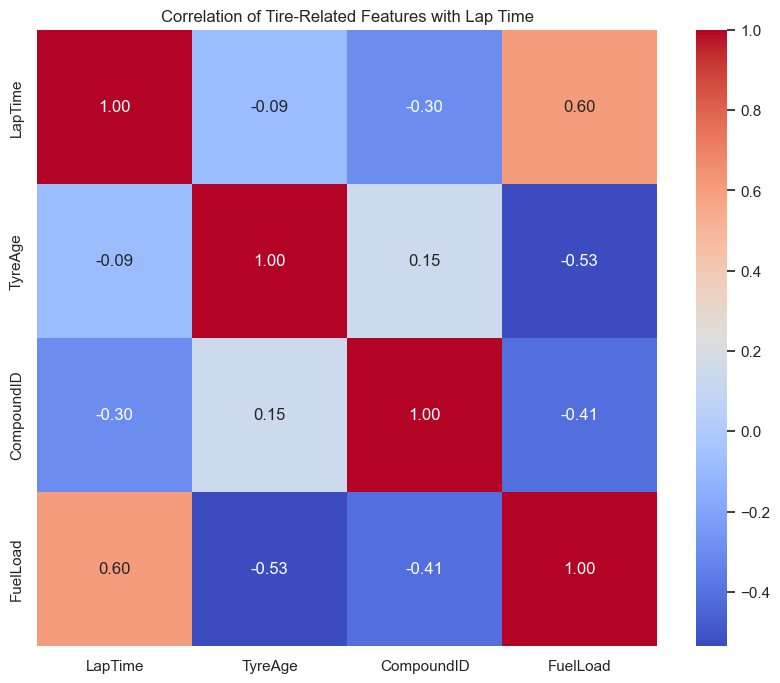

In [25]:


# Visualize the relationship between tire age and lap time
plt.figure(figsize=(12, 6))

# Group by compound and tire age
for compound_id in data['CompoundID'].unique():
    subset = data[data['CompoundID'] == compound_id]
    
    # Aggregate by tire age
    agg_data = subset.groupby('TyreAge')['LapTime'].agg(['mean', 'std', 'count']).reset_index()
    
    # Only plot if we have enough data points
    if len(agg_data) > 3:
        color = compound_colors.get(compound_id, 'black')
        compound_name = compound_names.get(compound_id, f'Unknown ({compound_id})')
        
        plt.plot(agg_data['TyreAge'], agg_data['mean'], 'o-', 
                 color=color, label=f'{compound_name} Tire')
        
        # Add error bands (standard deviation)
        plt.fill_between(agg_data['TyreAge'], 
                         agg_data['mean'] - agg_data['std'], 
                         agg_data['mean'] + agg_data['std'],
                         color=color, alpha=0.2)

plt.xlabel('Tire Age (laps)')
plt.ylabel('Lap Time (s)')
plt.title('Tire Degradation: Effect on Lap Time')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('../../outputs/week5/tire_deg_curve.png')
plt.show()

# Explore lap time deltas as tire ages
if 'LapTime_Delta' in seq_data.columns:
    plt.figure(figsize=(12, 6))
    
    for compound_id in seq_data['CompoundID'].unique():
        subset = seq_data[seq_data['CompoundID'] == compound_id]
        
        # Aggregate by tire age
        agg_data = subset.groupby('TyreAge')['LapTime_Delta'].mean().reset_index()
        
        # Only plot if we have enough data points
        if len(agg_data) > 3:
            color = compound_colors.get(compound_id, 'black')
            compound_name = compound_names.get(compound_id, f'Unknown ({compound_id})')
            
            plt.plot(agg_data['TyreAge'], agg_data['LapTime_Delta'], 'o-', 
                     color=color, label=f'{compound_name} Tire')
    
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    plt.xlabel('Tire Age (laps)')
    plt.ylabel('Lap Time Delta (s) - Positive means getting slower')
    plt.title('Lap Time Degradation Rate by Tire Age')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig('../../outputs/week5/tire_deg_rate.png')
    plt.show()

# Look at how tire age affects speed in different sectors
speed_columns = [col for col in data.columns if 'speed' in col.lower()]
if speed_columns:
    compound_id = 2  # Focus on medium tires as an example
    
    plt.figure(figsize=(14, 8))
    for speed_col in speed_columns:
        subset = data[data['CompoundID'] == compound_id]
        
        # Aggregate by tire age
        agg_data = subset.groupby('TyreAge')[speed_col].mean().reset_index()
        
        if len(agg_data) > 3:
            plt.plot(agg_data['TyreAge'], agg_data[speed_col], 'o-', 
                     label=f'{speed_col}')
    
    plt.xlabel('Tire Age (laps)')
    plt.ylabel('Speed (kph)')
    plt.title(f'Effect of Tire Age on Speed - {compound_names.get(compound_id)} Tires')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig('../../outputs/week5/tire_age_speed_effect.png')
    plt.show()

# Correlation between tire-related factors and lap time
selected_columns = ['LapTime', 'TyreAge', 'CompoundID', 'FuelLoad']
if 'TrackTemp' in data.columns:
    selected_columns.append('TrackTemp')

correlation = data[selected_columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation of Tire-Related Features with Lap Time')
plt.savefig('../../outputs/week5/tire_correlation.png')
plt.show()